# 新闻文本分类
tianchi: https://tianchi.aliyun.com/competition/entrance/531810/information

使用BertForSequenceClassification。这是正常的BERT模型，顶部添加了单个线性层进行分类，用作句子分类器。当我们输入数据时，整个预训练的BERT模型和额外的未经训练的分类层在我们的特定任务中进行训练。

## Import

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import f1_score

from transformers import AutoTokenizer, BertForSequenceClassification

计算f1分数

In [16]:
target = torch.tensor([0., 1., 2., 0., 1., 2.])
preds = torch.tensor([0., 2., 1., 0., 0., 1.])
target = target.type(torch.int32)
preds = preds.type(torch.int32)
f1_score(preds, target, num_classes=3)
# preds, target

tensor(0.3333)

## Data

In [17]:
train_set = pd.read_csv('./News/data/train_set.csv', sep='\t')
test_set = pd.read_csv('./News/data/test_a.csv', sep='\t')
train_set.shape, test_set.shape

((182924, 2), (50000, 1))

In [18]:
print(train_set.head())
print(len(train_set['text'][0]))

   label                                               text
0      2  2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1     11  4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2      3  7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3      2  7159 948 4866 2109 5520 2490 211 3956 5520 549...
4      3  3646 3055 3055 2490 4659 6065 3370 5814 2465 5...
5120


查看一下训练集每篇新闻长度的情况

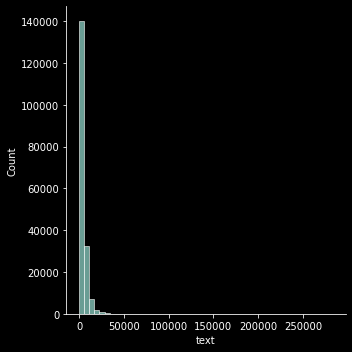

In [19]:
length = train_set['text'].apply(len)
sns.displot(length, bins=50)

查看测试集的长度情况

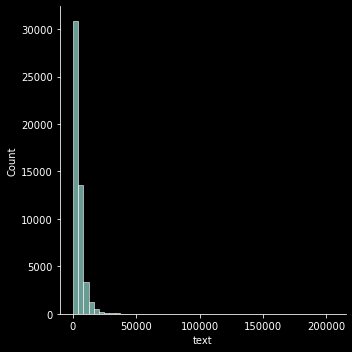

In [20]:
length = test_set['text'].apply(len)
sns.displot(length, bins=50)

## Process

格式化

1. 填充特殊词元
2. 将每个句子填充或截断为一个固定长度
3. 使用`mask attention`显式区分真实词元和填充词元

填充词元：
* [SEP]，添加在每个句子的末尾
* [CLS]，transformer层输出和输入长度相同的词嵌入向量，在分类时，只需要得到第一个词向量并进行分类即可

创建数据集

In [21]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.comment_text = self.df.text
        self.max_len = max_len
        if 'label' in self.df:
            self.targets = self.df.label

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = self.comment_text[index]

        encode_dict = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,    # 添加特殊token [CLS], [SEP]
            truncation=True,    # 是否截断超长句子
            max_length=self.max_len,    # 句子最大长度
            padding='max_length',   # 长度不够的填充至最大长度
            return_attention_mask=True,  # 是否返回attention mask
            return_tensors='pt', # 返回tensor类型
        )
        ids = encode_dict['input_ids']
        mask = encode_dict['attention_mask']

        ids = ids.squeeze(0)    # (1, max_len) -> (max_len)
        mask = mask.squeeze(0)  # (1, max_len) -> (max_len)
        
        if 'label' in self.df:
            target = self.targets[index]
            return {"ids" : ids, "mask": mask, "target": target}
        return {"ids": ids, "mask": mask}

In [22]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [23]:
max_len = 128
train_dataset = CustomDataset(train_set, tokenizer, max_len=max_len)
test_dataset = CustomDataset(test_set, tokenizer, max_len=max_len)

In [24]:
# loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# for batch in loader:
#     print(batch['ids'].shape, batch['mask'].shape, batch['target'].shape)
#     print(batch['target'])
#     model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=14, output_attentions=False, output_hidden_states=False)
#     loss, logits = model(batch['ids'], attention_mask=batch['mask'], labels=batch['target'], return_dict=False)
#     loss, logits
#     break

## Model

继承pytorch lightning框架的类，创建模型、定义forward函数、optimizer以及训练步骤和log。

学习率使用了指数衰减的方法，参数gamma表示衰减的底数，选择不同的gamma值可以获得幅度不同的衰减曲线。

In [25]:
class Classifier(pl.LightningModule):
    def __init__(self, hparams):
        super(Classifier, self).__init__()
        
        # 不返回attention weights和hidden states
        self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=14, output_attentions=False, output_hidden_states=False)
        
        self.batch_size = hparams["batch_size"]
        self.lr = hparams["lr"]
        self.gamma = hparams["gamma"]

    def forward(self, batch):
        if len(batch) == 3:
            input_ids, attention_masks, labels = batch['ids'], batch['mask'], batch['target']
            loss, logits = self.model(input_ids, attention_mask=attention_masks, labels=labels, token_type_ids=None, return_dict=False)
            return loss, logits
        else:
            input_ids, attention_mask = batch['ids'], batch['mask']
            logits = self.model(input_ids, token_type_ids=None, attention_mask=attention_mask)
            return logits[0]

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, self.gamma)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss, logits = self.forward(batch)
        
        pred_flat = torch.argmax(logits, dim=1).flatten()
        labels_flat = batch['target'].flatten()
        # acc = torch.sum(pred_flat == labels_flat) / len(labels_flat)
        # 计算f1 score
        f1 = f1_score(pred_flat, labels_flat, average="macro", num_classes=14)
        self.log("loss", loss)
        self.log("train_f1", f1)
        return loss

    # def training_epoch_end(self, outputs):
    #     avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
    #     avg_f1 = torch.stack([x["train_f1"] for x in outputs]).mean()
    #     self.log("step", self.trainer.current_epoch)
    #     self.log("avg_loss", avg_loss)
    #     self.log("avg_acc", avg_f1)

    # def validation_step(self, batch, batch_idx):
    #     loss, logits = self.forward(batch)
    #     pred_flat = torch.argmax(logits, dim=1).flatten()
    #     labels_flat = batch[2].flatten()
    #     f1 = f1_score(pred_flat, labels_flat, average="macro")
    #     return {"val_f1": f1}

    # def validation_epoch_end(self, outputs):
    #     avg_f1 = torch.stack([x["val_f1"] for x in outputs]).mean()
    #     self.log("val_f1", avg_f1)
    
    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    # def val_dataloader(self):
    #     valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, sampler=RandomSampler(valid_dataset))
    #     return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return test_loader

## Training

In [26]:
hparams = {
    "batch_size": 4,
    "lr": 2e-5,
    "gamma": 0.8,
}

model = Classifier(hparams)

checkpoint_callback = ModelCheckpoint(
    monitor="train_f1",
    dirpath="./ckpts/",
    mode='max',
    filename='best.pth',
)
trainer = pl.Trainer(gpus=1, max_epochs=1, log_every_n_steps=100, callbacks=[checkpoint_callback])
trainer.fit(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

## Inference

In [27]:
# model = Classifier(hparams).load_from_checkpoint("./ckpts/best.pth")
predictions = trainer.predict(model, model.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\69570\miniconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 16378it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
preds = []
for batch in predictions:
  preds.extend(batch.argmax(dim=1).numpy())

submission = pd.read_csv("./News/data/test_a_sample_submit.csv")
submission["label"] = preds
submission.to_csv("./submission.csv", index=False)